# Bitcoin Price Movement Prediction
Konstantinos Papakostas - papakosk@csd.auth.gr

In [ ]:
!pip install pandas_ta

## Data Preparation

### Dataset Creation

In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

In [3]:
def drop_before(df, date, timestamp_col='Timestamp'):
    return df[~(df[timestamp_col] < date)]

def drop_after(df, date, timestamp_col='Timestamp'):
    return df[~(df[timestamp_col] > date)]

def drop_time(df, timestamp_col='Timestamp'):
    df[timestamp_col] = df[timestamp_col].apply(lambda t: t.split(' ', 1)[0])
    return df

#### Bitcoincharts

In [4]:
# BTC price & volumes from Bitcoincharts
# https://bitcoincharts.com/charts/bitstampUSD#igDailyztgCzm1g10zm2g25zv
charts = pd.read_csv("_price.csv")
charts.drop(columns=['Volume (BTC)', 'Weighted Price'], inplace=True)

charts = drop_time(charts)
charts = drop_before(charts, '2011-12-18')

charts['Timestamp'] = pd.to_datetime(charts['Timestamp'])
charts.set_index('Timestamp', inplace=True)

charts.tail()

,Open,High,Low,Close,Volume (USD)
Timestamp,,,,,
2021-05-04,57227.64,57250.85,53080.69,53236.84,3.169453e+08
2021-05-05,53221.75,57976.62,52924.50,57509.93,3.092337e+08
2021-05-06,57517.08,58420.83,55283.00,56447.39,2.922233e+08
2021-05-07,56425.82,58743.85,55288.11,57381.73,2.414859e+08
2021-05-08,57371.02,59501.00,56977.50,59225.34,1.533003e+08


#### Google Trends

In [5]:
# from pytrends import dailydata

# trends = dailydata.get_daily_data('Bitcoin', 2011, 12, 2021, 5, verbose=False)

# trends.index.name = 'Timestamp'
# trends.reset_index(inplace=True)
# trends = drop_before(trends, '2011-12-18')
# trends = drop_after(trends, '2021-05-07')
# trends.set_index('Timestamp', inplace=True)

# trends = trends[['Bitcoin']]
# trends.columns = ['Google Trends']

trends = pd.read_csv("_google.csv")
trends['Timestamp'] = pd.to_datetime(trends['Timestamp'])
trends.set_index("Timestamp", inplace=True)
trends.tail()

,Google Trends
Timestamp,
2021-05-03,12.42
2021-05-04,14.26
2021-05-05,14.26
2021-05-06,13.80
2021-05-07,12.88


#### Stooq (S&P 500)

In [6]:
# S&P 500 data from Stooq.com
# https://stooq.com/q/d/?s=^spx&i=d&d1=20111216&d2=20210525
spx = pd.read_csv("_spx.csv").set_index('Date')
spx.columns = [f"S&P {col}" for col in spx.columns]

index_list = list(spx.index)
index_list[0] = '2011-12-18'
spx.index = pd.to_datetime(index_list)
spx.index.name = 'Timestamp'

spx = spx[['S&P Close']]
spx.head()

,S&P Close
Timestamp,
2011-12-18,1219.66
2011-12-19,1205.35
2011-12-20,1241.30
2011-12-21,1243.72
2011-12-22,1254.00


#### Investing.com (Forex)

In [7]:
# Currency exchange rates from investing.com
# https://www.investing.com/currencies
from datetime import datetime

currencies = None

for f_name in glob.glob("_rate_*.csv"):
    df = pd.read_csv(f_name)
    df = df[['Date', 'Price']]

    rate_name = f_name[len("_rate_"):-len(".csv")].replace("_", "/")
    df.columns = ["Timestamp", rate_name]

    df['Timestamp'] = df['Timestamp'].apply(lambda d: datetime.strptime(d, "%b %d, %Y"))
    df.set_index('Timestamp', inplace=True)

    if currencies is None:
        currencies = df
    else:
        currencies = currencies.join(df)

currencies.head()

,CHF/USD,CNY/USD,EUR/USD,GBP/USD
Timestamp,,,,
2021-05-07,1.1095,0.1554,1.2163,1.3972
2021-05-06,1.1017,0.1546,1.2064,1.3885
2021-05-05,1.0951,0.1545,1.2005,1.3903
2021-05-04,1.0942,0.1545,1.2013,1.3885
2021-05-03,1.0975,0.1545,1.2061,1.3909


#### Blockchain.com

In [8]:
# BTC blockchain info from Blockchain.com
# https://www.blockchain.com/charts
blockchain = None

for f_name in glob.glob("*.csv"):
    if f_name.startswith("_"):
        continue

    df = pd.read_csv(f_name)
    df = drop_time(df)
    df = drop_before(df, '2011-12-18')

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.set_index("Timestamp", inplace=True)

    if blockchain is None:
        blockchain = df
    else:
        blockchain = blockchain.join(df)

blockchain.head()

,avg-block-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions,n-unique-addresses,output-volume,transaction-fees-usd,transaction-fees
Timestamp,,,,,,,,,,,,,,,,,
2011-12-18,0.013470,9.548591,5.239323,1.155038e+06,260578.174256,80674.357355,0.002220,8.440338,9.233333,24881.544519,4632.0,32.166667,4632.0,8017.0,332854.351867,10.544519,3.101260
2011-12-19,0.017312,5.167330,4.570362,1.155038e+06,582248.419856,173288.220195,0.002232,8.670007,16.033333,30086.695562,5844.0,36.754717,5844.0,9898.0,485365.338244,14.695562,4.157304
2011-12-20,0.024973,3.123257,4.286866,1.155038e+06,897518.771559,230724.619938,0.003642,7.751331,14.900000,28031.817659,6295.0,46.977612,6295.0,10326.0,532264.086463,23.817659,5.906735
2011-12-21,0.016325,5.264362,5.933252,1.155038e+06,808890.942720,183421.982476,0.003685,8.899676,12.925000,42582.949408,5577.0,37.429530,5577.0,9152.0,579749.009432,26.449408,4.260752
2011-12-22,0.017319,6.706716,5.449301,1.155038e+06,596466.509857,146192.772024,0.002631,7.923583,14.600000,40003.315971,5859.0,39.587838,5859.0,9649.0,438479.169716,19.315971,3.453472


In [9]:
# def sin_cos_series(data):
#     transform = 2 * np.pi * np.array(data) / (np.max(data) - np.min(data))
#     sin_series = pd.Series(np.sin(transform))
#     cos_series = pd.Series(np.cos(transform))
#     return sin_series, cos_series

# months = [ts.month for ts in charts.index]
# (m_sin, m_cos) = sin_cos_series(months)

# days = [ts.day for ts in charts.index]
# (d_sin, d_cos) = sin_cos_series(days)

# cal = { "Month (sine)": m_sin, "Month (cosine)": m_cos, "Day (sine)": d_sin, "Day (cosine)": d_cos }
# cal = pd.DataFrame(cal)
# cal.index = charts.index

# cal.head()

In [10]:
df = charts.join(spx).join(currencies).join(blockchain).join(trends)
df.head()

,Open,High,Low,Close,Volume (USD),S&P Close,CHF/USD,CNY/USD,EUR/USD,GBP/USD,...,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions,n-unique-addresses,output-volume,transaction-fees-usd,transaction-fees,Google Trends
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-18,3.25,3.50,3.25,3.50,58.59,1219.66,NaN,NaN,NaN,NaN,...,9.233333,24881.544519,4632.0,32.166667,4632.0,8017.0,332854.351867,10.544519,3.101260,0.0
2011-12-19,3.50,3.98,3.50,3.85,513.29,1205.35,1.0667,0.1578,1.2995,1.5499,...,16.033333,30086.695562,5844.0,36.754717,5844.0,9898.0,485365.338244,14.695562,4.157304,0.0
2011-12-20,4.75,4.75,4.53,4.55,432.98,1241.30,1.0735,0.1576,1.3079,1.5656,...,14.900000,28031.817659,6295.0,46.977612,6295.0,10326.0,532264.086463,23.817659,5.906735,0.0
2011-12-21,4.38,4.38,4.38,4.38,91.54,1243.72,1.0684,0.1578,1.3045,1.5675,...,12.925000,42582.949408,5577.0,37.429530,5577.0,9152.0,579749.009432,26.449408,4.260752,0.0
2011-12-22,4.19,4.19,4.17,4.17,35.71,1254.00,1.0678,0.1577,1.3051,1.5675,...,14.600000,40003.315971,5859.0,39.587838,5859.0,9649.0,438479.169716,19.315971,3.453472,0.0


### Data Imputation

In [11]:
# fix incorrect infinity values in volume series
df['Volume (USD)'] = df['Volume (USD)'].replace([np.inf, -np.inf, 0.0], np.nan).interpolate()

In [12]:
# fill missing values with the next one available (chronologically)
for col in ['n-unique-addresses', 'CNY/USD', 'EUR/USD', 'CHF/USD', 'GBP/USD']:
    df[col] = df[col].bfill()

In [13]:
# fill missing values with the previous one available (chronologically)
df['S&P Close'] = df['S&P Close'].ffill()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3430 entries, 2011-12-18 to 2021-05-08
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Open                              3430 non-null   float64
 1   High                              3430 non-null   float64
 2   Low                               3430 non-null   float64
 3   Close                             3430 non-null   float64
 4   Volume (USD)                      3430 non-null   float64
 5   S&P Close                         3430 non-null   float64
 6   CHF/USD                           3429 non-null   float64
 7   CNY/USD                           3429 non-null   float64
 8   EUR/USD                           3429 non-null   float64
 9   GBP/USD                           3429 non-null   float64
 10  avg-block-size                    3429 non-null   float64
 11  cost-per-transaction-percent      3429 non-null   f

### Feature Selection

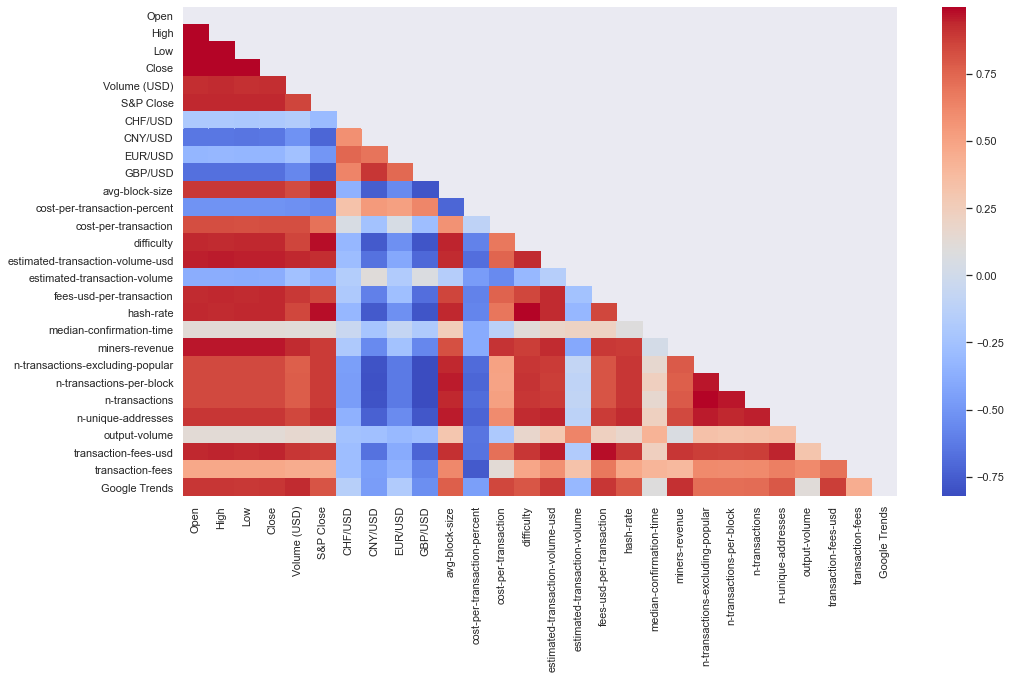

In [15]:
spear_corr = df.corr('spearman')
mask = np.triu(spear_corr)

fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(spear_corr, cmap='coolwarm', mask=mask, ax=ax);

In [16]:
close_corr = spear_corr['Close'].apply(abs)
close_corr.sort_values(ascending=False)

Close                               1.000000
High                                0.999642
Open                                0.999353
Low                                 0.999205
miners-revenue                      0.968044
estimated-transaction-volume-usd    0.956597
transaction-fees-usd                0.942834
S&P Close                           0.938270
difficulty                          0.936627
hash-rate                           0.936136
fees-usd-per-transaction            0.935825
Volume (USD)                        0.925129
Google Trends                       0.902132
n-unique-addresses                  0.901492
avg-block-size                      0.896855
n-transactions                      0.848586
n-transactions-excluding-popular    0.845546
n-transactions-per-block            0.845355
cost-per-transaction                0.831109
GBP/USD                             0.668510
CNY/USD                             0.642996
cost-per-transaction-percent        0.511847
transactio

In [17]:
features = close_corr[(close_corr > 0.6) & (close_corr < 0.95)]
features

Volume (USD)                        0.925129
S&P Close                           0.938270
CNY/USD                             0.642996
GBP/USD                             0.668510
avg-block-size                      0.896855
cost-per-transaction                0.831109
difficulty                          0.936627
fees-usd-per-transaction            0.935825
hash-rate                           0.936136
n-transactions-excluding-popular    0.845546
n-transactions-per-block            0.845355
n-transactions                      0.848586
n-unique-addresses                  0.901492
transaction-fees-usd                0.942834
Google Trends                       0.902132
Name: Close, dtype: float64

In [18]:
df_select = df[features.index]
df_select.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3430 entries, 2011-12-18 to 2021-05-08
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Volume (USD)                      3430 non-null   float64
 1   S&P Close                         3430 non-null   float64
 2   CNY/USD                           3429 non-null   float64
 3   GBP/USD                           3429 non-null   float64
 4   avg-block-size                    3429 non-null   float64
 5   cost-per-transaction              3429 non-null   float64
 6   difficulty                        3429 non-null   float64
 7   fees-usd-per-transaction          3429 non-null   float64
 8   hash-rate                         3429 non-null   float64
 9   n-transactions-excluding-popular  3429 non-null   float64
 10  n-transactions-per-block          3429 non-null   float64
 11  n-transactions                    3429 non-null   f

### Technical Indicators

In [19]:
import pandas_ta as ta

charts_tech = charts.iloc[:, :-1].copy()
charts_tech.columns = [col.lower() for col in charts_tech.columns]

fill = { "fill_method": "bfill" }
charts_tech.ta.sma(append=True, **fill)
charts_tech.ta.cci(append=True, **fill)
charts_tech.ta.rsi(append=True, **fill)

charts_tech = charts_tech.iloc[:, 3:] # drop open, high, low
charts_tech.head()

,close,SMA_10,CCI_14_0.015,RSI_14
timestamp,,,,
2011-12-18,3.50,4.189,92.679128,75.142158
2011-12-19,3.85,4.189,92.679128,75.142158
2011-12-20,4.55,4.189,92.679128,75.142158
2011-12-21,4.38,4.189,92.679128,75.142158
2011-12-22,4.17,4.189,92.679128,75.142158


In [20]:
df_full = df_select.join(charts_tech)
df_full.head()

,Volume (USD),S&P Close,CNY/USD,GBP/USD,avg-block-size,cost-per-transaction,difficulty,fees-usd-per-transaction,hash-rate,n-transactions-excluding-popular,n-transactions-per-block,n-transactions,n-unique-addresses,transaction-fees-usd,Google Trends,close,SMA_10,CCI_14_0.015,RSI_14
Timestamp,,,,,,,,,,,,,,,,,,,
2011-12-18,58.59,1219.66,0.1578,1.5499,0.013470,5.239323,1.155038e+06,0.002220,8.440338,4632.0,32.166667,4632.0,8017.0,10.544519,0.0,3.50,4.189,92.679128,75.142158
2011-12-19,513.29,1205.35,0.1578,1.5499,0.017312,4.570362,1.155038e+06,0.002232,8.670007,5844.0,36.754717,5844.0,9898.0,14.695562,0.0,3.85,4.189,92.679128,75.142158
2011-12-20,432.98,1241.30,0.1576,1.5656,0.024973,4.286866,1.155038e+06,0.003642,7.751331,6295.0,46.977612,6295.0,10326.0,23.817659,0.0,4.55,4.189,92.679128,75.142158
2011-12-21,91.54,1243.72,0.1578,1.5675,0.016325,5.933252,1.155038e+06,0.003685,8.899676,5577.0,37.429530,5577.0,9152.0,26.449408,0.0,4.38,4.189,92.679128,75.142158
2011-12-22,35.71,1254.00,0.1577,1.5675,0.017319,5.449301,1.155038e+06,0.002631,7.923583,5859.0,39.587838,5859.0,9649.0,19.315971,0.0,4.17,4.189,92.679128,75.142158


### Calculating Target Value

In [21]:
buy = []
diff = []

closes = df_full['close']

prev_close = closes.iloc[0]
for close in closes.iloc[1:]:
    buy.append(close > prev_close)
    diff.append(close - prev_close)
    prev_close = close

buy = pd.Series(buy, name='Buy', dtype=int)
diff = pd.Series(diff, name='Price Diff')

dataset = df_full.iloc[:-1]
buy.index = dataset.index
diff.index = dataset.index

dataset = dataset.join(buy).join(diff)

for int_col in ['n-transactions-excluding-popular', 'n-transactions', 'n-unique-addresses']:
    dataset[int_col] = dataset[int_col].astype(int)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3429 entries, 2011-12-18 to 2021-05-07
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Volume (USD)                      3429 non-null   float64
 1   S&P Close                         3429 non-null   float64
 2   CNY/USD                           3429 non-null   float64
 3   GBP/USD                           3429 non-null   float64
 4   avg-block-size                    3429 non-null   float64
 5   cost-per-transaction              3429 non-null   float64
 6   difficulty                        3429 non-null   float64
 7   fees-usd-per-transaction          3429 non-null   float64
 8   hash-rate                         3429 non-null   float64
 9   n-transactions-excluding-popular  3429 non-null   int32  
 10  n-transactions-per-block          3429 non-null   float64
 11  n-transactions                    3429 non-null   i

### Data Visualisation

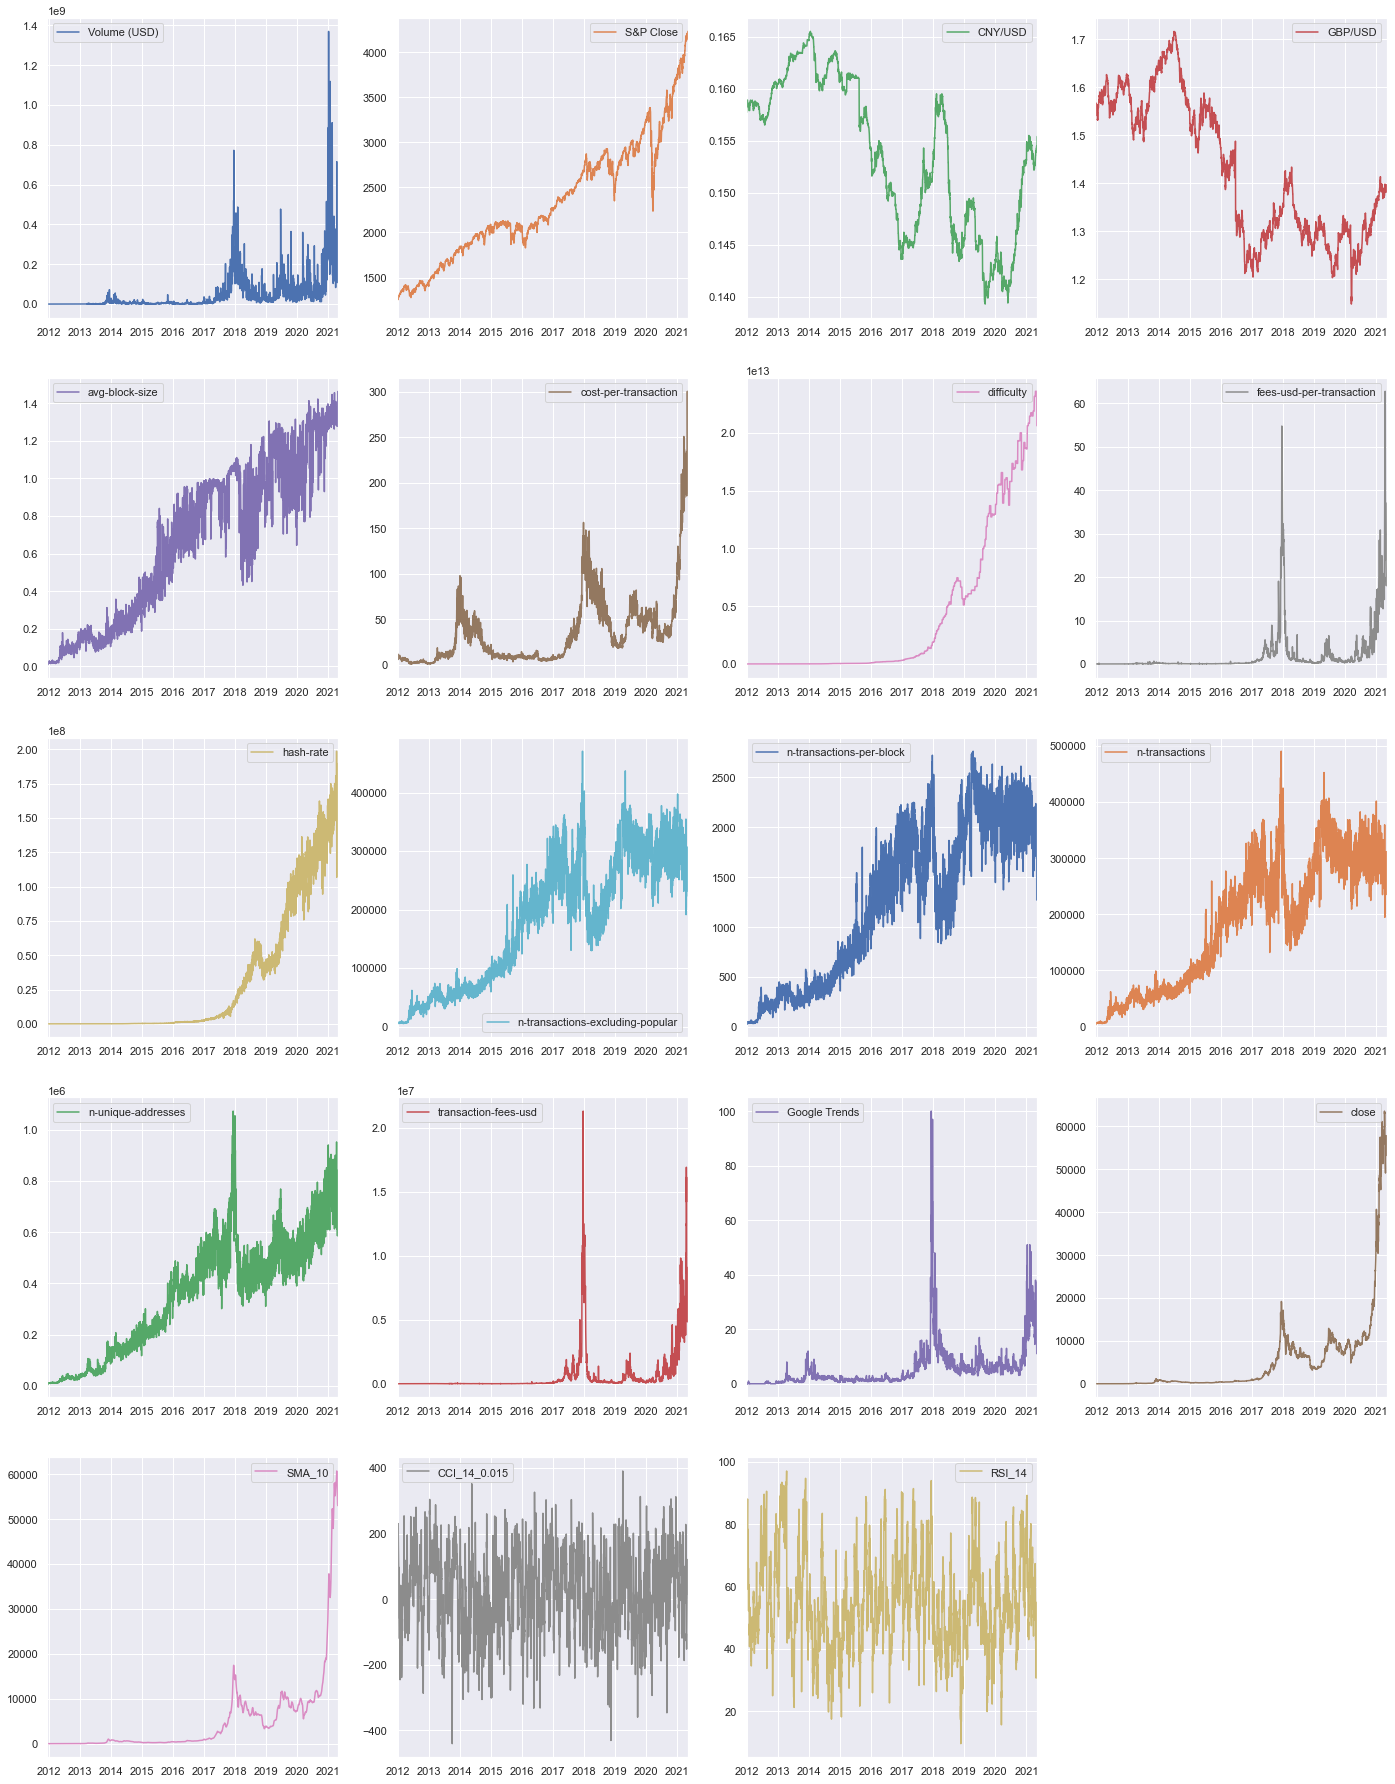

In [22]:
dataset.iloc[:, :-2].plot(subplots=True, figsize=(24,32), layout=(5,4), sharex=False, xlabel='');

### Data Scaling

In [23]:
dataset.head()

,Volume (USD),S&P Close,CNY/USD,GBP/USD,avg-block-size,cost-per-transaction,difficulty,fees-usd-per-transaction,hash-rate,n-transactions-excluding-popular,...,n-transactions,n-unique-addresses,transaction-fees-usd,Google Trends,close,SMA_10,CCI_14_0.015,RSI_14,Buy,Price Diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-18,58.59,1219.66,0.1578,1.5499,0.013470,5.239323,1.155038e+06,0.002220,8.440338,4632,...,4632,8017,10.544519,0.0,3.50,4.189,92.679128,75.142158,1,0.35
2011-12-19,513.29,1205.35,0.1578,1.5499,0.017312,4.570362,1.155038e+06,0.002232,8.670007,5844,...,5844,9898,14.695562,0.0,3.85,4.189,92.679128,75.142158,1,0.70
2011-12-20,432.98,1241.30,0.1576,1.5656,0.024973,4.286866,1.155038e+06,0.003642,7.751331,6295,...,6295,10326,23.817659,0.0,4.55,4.189,92.679128,75.142158,0,-0.17
2011-12-21,91.54,1243.72,0.1578,1.5675,0.016325,5.933252,1.155038e+06,0.003685,8.899676,5577,...,5577,9152,26.449408,0.0,4.38,4.189,92.679128,75.142158,0,-0.21
2011-12-22,35.71,1254.00,0.1577,1.5675,0.017319,5.449301,1.155038e+06,0.002631,7.923583,5859,...,5859,9649,19.315971,0.0,4.17,4.189,92.679128,75.142158,1,0.05


In [24]:
dataset_X = dataset.iloc[:, :-2]
dataset_Y = dataset.iloc[:, -2:]

dataset_X.describe()

,Volume (USD),S&P Close,CNY/USD,GBP/USD,avg-block-size,cost-per-transaction,difficulty,fees-usd-per-transaction,hash-rate,n-transactions-excluding-popular,n-transactions-per-block,n-transactions,n-unique-addresses,transaction-fees-usd,Google Trends,close,SMA_10,CCI_14_0.015,RSI_14
count,3.429000e+03,3429.000000,3429.000000,3429.000000,3429.000000,3429.000000,3.429000e+03,3429.000000,3.429000e+03,3429.000000,3429.000000,3429.000000,3.429000e+03,3.429000e+03,3429.000000,3429.000000,3429.000000,3429.000000,3429.000000
mean,4.685611e+07,2328.051770,0.153615,1.428166,0.670724,33.697886,4.174354e+12,2.046771,3.038140e+07,181667.360163,1250.291116,186142.908428,3.581829e+05,6.144219e+05,5.204593,5163.657754,5089.434512,22.911669,55.227005
std,9.346526e+07,662.226916,0.007303,0.145733,0.424253,38.218741,6.488970e+12,5.640839,4.714976e+07,111463.169757,795.460734,115619.874467,2.350876e+05,1.751436e+06,7.480523,9822.895659,9626.855883,111.239127,14.870289
min,1.230000e+00,1205.350000,0.139300,1.148500,0.012890,0.728496,1.155038e+06,0.001821,7.380532e+00,4632.000000,30.379310,4632.000000,7.872000e+03,9.420278e+00,0.000000,3.500000,4.189000,-440.872064,9.632983
25%,1.782948e+06,1868.990000,0.146700,1.297100,0.219446,7.706528,6.978843e+09,0.060337,5.758874e+04,66233.000000,401.958333,66233.000000,1.436450e+05,5.312438e+03,1.200000,245.000000,244.315000,-60.234735,45.124899
50%,8.310480e+06,2153.740000,0.154300,1.396700,0.757549,21.030937,2.173755e+11,0.200405,1.644958e+06,198793.000000,1348.927007,205208.000000,3.957200e+05,4.140065e+04,2.600000,709.310000,706.812000,31.980961,53.346861
75%,5.278223e+07,2796.110000,0.160500,1.563600,1.017521,48.413917,6.389317e+12,1.162526,4.615799e+07,283137.000000,2001.926174,290208.000000,5.368210e+05,3.319983e+05,6.480000,7361.000000,7340.976000,106.218256,64.902024
max,1.369434e+09,4232.600000,0.165500,1.716600,1.462601,300.310549,2.358198e+13,62.788166,1.985140e+08,470650.000000,2762.540984,490644.000000,1.072862e+06,2.128565e+07,100.000000,63564.480000,60704.230000,390.563914,97.088945


In [25]:
from sklearn.preprocessing import StandardScaler

dataset_scaled = dataset_X

# convert certain features to log scale
# log_features = ['transaction-fees-usd', 'hash-rate', 'estimated-transaction-volume-usd', 'n-unique-addresses', 'miners-revenue', 'difficulty']
log_features = ['Volume (USD)', 'transaction-fees-usd', 'hash-rate', 'n-unique-addresses', 'difficulty']
dataset_scaled[log_features] = np.log10(dataset_scaled[log_features].values)

# perform standardization
scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(dataset_scaled)
dataset_scaled = pd.DataFrame(dataset_scaled, index=dataset_X.index, columns=dataset_X.columns)

# create scaled dataset by concatenating
dataset_scaled = dataset_scaled.join(dataset_Y)
dataset_scaled.head()

,Volume (USD),S&P Close,CNY/USD,GBP/USD,avg-block-size,cost-per-transaction,difficulty,fees-usd-per-transaction,hash-rate,n-transactions-excluding-popular,...,n-transactions,n-unique-addresses,transaction-fees-usd,Google Trends,close,SMA_10,CCI_14_0.015,RSI_14,Buy,Price Diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-18,-3.612215,-1.673978,0.573076,0.835449,-1.549428,-0.744732,-2.037427,-0.362508,-2.053332,-1.588517,...,-1.570123,-2.961281,-2.697568,-0.695854,-0.525396,-0.528312,0.627276,1.339453,1,0.35
2011-12-19,-2.925109,-1.695590,0.573076,0.835449,-1.540371,-0.762238,-2.037427,-0.362506,-2.048304,-1.577642,...,-1.559638,-2.776604,-2.587202,-0.695854,-0.525360,-0.528312,0.627276,1.339453,1,0.70
2011-12-20,-2.978978,-1.641296,0.545687,0.943196,-1.522309,-0.769657,-2.037427,-0.362256,-2.069278,-1.573595,...,-1.555737,-2.739512,-2.426649,-0.695854,-0.525289,-0.528312,0.627276,1.339453,0,-0.17
2011-12-21,-3.470945,-1.637641,0.573076,0.956236,-1.542697,-0.726572,-2.037427,-0.362248,-2.043408,-1.580038,...,-1.561948,-2.845264,-2.391802,-0.695854,-0.525306,-0.528312,0.627276,1.339453,0,-0.21
2011-12-22,-3.768974,-1.622115,0.559382,0.956236,-1.540353,-0.739237,-2.037427,-0.362435,-2.065163,-1.577508,...,-1.559509,-2.798928,-2.496304,-0.695854,-0.525328,-0.528312,0.627276,1.339453,1,0.05


## Model Training

### Methods

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [27]:
def plot_model_hist(hist):
    history = hist.history
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['accuracy']
    val_acc = history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))

    ax1.plot(loss, c='red', label='Training Loss')
    ax1.plot( val_loss, c='orange', label='Validation Loss')
    ax2.plot(acc, c='lime', label='Training Accuracy')
    ax2.plot(val_acc, c='turquoise', label='Validation Accuracy')
    ax1.legend() ; ax2.legend()

In [28]:
def display_grid_results(grid, params):
    params = [f"param_{p}" for p in params]
    params.extend(['mean_fit_time', 'std_fit_time', 'mean_test_score', 'std_test_score', 'rank_test_score'])
    
    df_res = pd.DataFrame(grid.cv_results_)
    display(df_res[params].sort_values('rank_test_score').reset_index(drop=True).iloc[:, :-1])

In [29]:
binarize = np.vectorize(lambda x: 1 if x >= 0.5 else 0)

### Dataset Splitting

In [30]:
def split_blocks(X, Y, block_size):
    X_blocks, Y_blocks = [], []
    for i in range(X.shape[0] - block_size + 1):
        X_blocks.append(X[i : i + block_size])
        Y_blocks.append(Y[i + block_size - 1])
    
    return np.array(X_blocks), np.array(Y_blocks)

In [31]:
X = dataset_scaled.iloc[:, :-2]
Y = dataset_scaled.iloc[:, -2:]

end = round(0.94 * len(dataset_scaled))
Xs = dataset_scaled.iloc[:end, :-2]
Ys = dataset_scaled.iloc[:end, -2:]

# drop "Price Diff" feature for classification
Y = Y.iloc[:, -2]
Ys = Ys.iloc[:, -2]

X_train, x_test, Y_train, y_test = train_test_split(X.values, Y.values, test_size=0.2, shuffle=False, random_state=42)
Xs_train, xs_test, Ys_train, ys_test = train_test_split(Xs.values, Ys.values, test_size=0.2, shuffle=False, random_state=42)

block_size = 100

X_train_blocks, Y_train_blocks = split_blocks(X_train, Y_train, block_size)
x_test_blocks, y_test_blocks = split_blocks(x_test, y_test, block_size)

Xs_train_blocks, Ys_train_blocks = split_blocks(Xs_train, Ys_train, block_size)
xs_test_blocks, ys_test_blocks = split_blocks(xs_test, ys_test, block_size)

In [32]:
X_train_blocks.shape

(2644, 100, 19)

In [33]:
Y_train_blocks.shape

(2644,)

In [34]:
train_s_pos_pct = 100 * np.sum(Ys_train_blocks) / len(Ys_train_blocks)
test_s_pos_pct = 100 * np.sum(ys_test_blocks) / len(ys_test_blocks)

print("Smaller dataset")
print(f"Train set: positive {train_s_pos_pct:.2f}%")
print(f"Test set: positive {test_s_pos_pct:.2f}%")

Smaller dataset
Train set: positive 54.13%
Test set: positive 52.93%


In [35]:
train_pos_pct = 100 * np.sum(Y_train_blocks) / len(Y_train_blocks)
test_pos_pct = 100 * np.sum(y_test_blocks) / len(y_test_blocks)

print("Entire dataset")
print(f"Train set: positive {train_pos_pct:.2f}%")
print(f"Test set: positive {test_pos_pct:.2f}%")

Entire dataset
Train set: positive 54.50%
Test set: positive 54.34%


### Support Vector Machine

#### GridSearch for smaller dataset

In [37]:
from sklearn.svm import SVC

features_s = Xs_train_blocks.shape[1] * Xs_train_blocks.shape[2]
train_s_shape = (len(Xs_train_blocks), features_s)

svm = SVC(random_state=42)
param_grid_s = {
    'C': [ 0.7, 0.8, 0.9 ],
    'class_weight': [{0: 1, 1: n} for n in [1, 2]]
}

grid_s = GridSearchCV(svm, param_grid_s, cv=TimeSeriesSplit(), verbose=1)
grid_s.fit(Xs_train_blocks.reshape(train_s_shape), Ys_train_blocks);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [38]:
display_grid_results(grid_s, param_grid_s.keys())

,param_C,param_class_weight,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,0.7,"{0: 1, 1: 2}",1.247202,0.913472,0.534625,0.052210
1,0.8,"{0: 1, 1: 2}",1.125003,0.919628,0.534625,0.052210
2,0.9,"{0: 1, 1: 2}",1.111602,0.909064,0.534625,0.052210
3,0.7,"{0: 1, 1: 1}",1.474971,1.055708,0.518644,0.056358
4,0.9,"{0: 1, 1: 1}",1.191402,0.972444,0.518644,0.058481
5,0.8,"{0: 1, 1: 1}",1.205803,0.970900,0.518160,0.057032


In [39]:
test_s_shape = (len(xs_test_blocks), features_s)

model_s = grid_s.best_estimator_
model_s.score(xs_test_blocks.reshape(test_s_shape), ys_test_blocks)

0.5293040293040293

In [40]:
print(classification_report(ys_test_blocks, model_s.predict(xs_test_blocks.reshape(test_s_shape))))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       257
           1       0.53      1.00      0.69       289

    accuracy                           0.53       546
   macro avg       0.26      0.50      0.35       546
weighted avg       0.28      0.53      0.37       546



C:\Users\dinos\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dinos\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dinos\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### GridSearch for the entire dataset

In [107]:
from sklearn.svm import SVC

features = X_train_blocks.shape[1] * X_train_blocks.shape[2]
train_shape = (len(X_train_blocks), features)

svm = SVC(random_state=42)
param_grid = {
    'C': [ 1.1, 1.3 ],
    'tol': [ 1e-5, 1e-3, 1e-4 ]
}

grid = GridSearchCV(svm, param_grid, cv=TimeSeriesSplit(), verbose=1)
grid.fit(X_train_blocks.reshape(train_shape), Y_train_blocks);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [105]:
display_grid_results(grid, param_grid.keys())

,param_C,param_tol,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,1.3,0.0001,1.925358,1.585341,0.549091,0.019210
1,1.3,0.001,1.908165,1.458872,0.548636,0.019477
2,1.1,0.01,1.605403,1.325384,0.548182,0.017153
3,1.3,0.01,1.729804,1.452681,0.548182,0.019782
4,1.1,0.001,1.726601,1.468601,0.547727,0.017368
5,1.1,0.0001,1.655203,1.259945,0.547727,0.017368
6,1.0,0.01,1.750009,1.183199,0.546364,0.015521
7,1.0,0.001,1.577803,1.287946,0.546364,0.015521
8,1.0,0.0001,1.583805,1.271459,0.546364,0.015521


In [108]:
test_shape = (len(x_test_blocks), features)

model = grid.best_estimator_
model.score(x_test_blocks.reshape(test_shape), y_test_blocks)

0.5315161839863713

In [109]:
print(classification_report(y_test_blocks, model.predict(x_test_blocks.reshape(test_shape))))

              precision    recall  f1-score   support

           0       0.48      0.41      0.45       268
           1       0.56      0.63      0.59       319

    accuracy                           0.53       587
   macro avg       0.52      0.52      0.52       587
weighted avg       0.53      0.53      0.53       587



### Deep Neural Network

In [43]:
def build_dnn(input_shape, units, dropout=0.0, activation='relu', optimizer='adam'):
    # build a sequential model
    model = models.Sequential()

    # add input layer
    model.add(layers.InputLayer(input_shape=input_shape, name='input'))

    # add hidden layers
    for unit in units.split(","):
        model.add(layers.Dense(units=unit, activation=activation))

        # add dropout if needed
        if dropout != 0.0:
            model.add(layers.Dropout(dropout))

    # add flatten layer
    model.add(layers.Flatten())
    
    # add output layer
    model.add(layers.Dense(units=1, activation='sigmoid', name='output'))

    # compile and train for accuravy optimization
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

#### GridSearch for smaller dataset

In [80]:
input_shape_s = Xs_train_blocks.shape[1:]
clf = KerasClassifier(build_fn=build_dnn, input_shape=input_shape_s)

param_grid_s = {
    'units': [ '4,8,4', '8,16,8', '16,32,16', '32,64,32', '8,16,16,8' ],
    'dropout': [ 0.1, 0.2, 0.3 ]
}

grid_s = GridSearchCV(clf, param_grid_s, cv=TimeSeriesSplit(), verbose=1)
grid_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=50, verbose=0);

Fitting 5 folds for each of 15 candidates, totalling 75 fits
13/13 [==============================] - 0s 3ms/step - loss: 0.7260 - accuracy: 0.4988


In [81]:
display_grid_results(grid_s, param_grid_s.keys())

,param_units,param_dropout,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,"4,8,4",0.2,1.320600,0.270803,0.538015,0.043916
1,"16,32,16",0.3,1.725306,0.578783,0.531235,0.051126
2,"8,16,16,8",0.3,1.926071,0.339322,0.530751,0.059731
3,"4,8,4",0.3,1.546399,0.407234,0.528329,0.050125
4,"8,16,8",0.2,1.532599,0.318515,0.526392,0.045002
5,"8,16,8",0.3,1.645659,0.283726,0.517191,0.043519
6,"8,16,16,8",0.2,1.738999,0.445552,0.515739,0.046145
7,"8,16,16,8",0.1,1.725457,0.197579,0.514770,0.054543
8,"16,32,16",0.1,1.500642,0.432042,0.512833,0.048412
9,"4,8,4",0.1,1.706200,0.279646,0.507506,0.036612


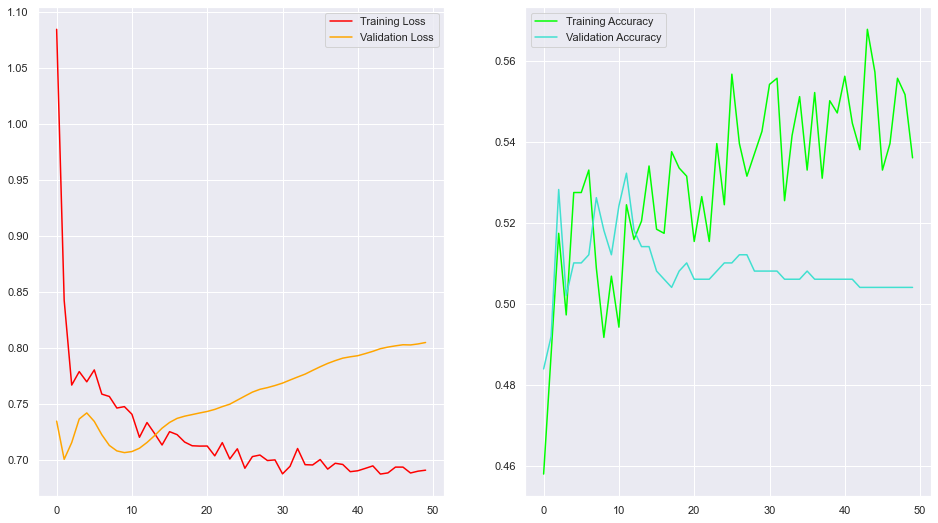

In [82]:
model_s = grid_s.best_estimator_
hist_s = model_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=50, validation_split=0.2, shuffle=False, verbose=0)
plot_model_hist(hist_s)

In [96]:
model_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=50, verbose=0)
model_s.score(xs_test_blocks, ys_test_blocks)

18/18 [==============================] - 0s 2ms/step - loss: 0.6913 - accuracy: 0.5293


0.529304027557373

#### GridSearch for the entire dataset

In [84]:
input_shape = X_train_blocks.shape[1:]
clf = KerasClassifier(build_fn=build_dnn, input_shape=input_shape, activation='tanh')

param_grid = {
    'units': [ '4,8,4', '16,32,16', '8,16,16,8' ],
    'dropout': [ 0.1, 0.2, 0.4 ],
}

grid = GridSearchCV(clf, param_grid, cv=TimeSeriesSplit(), verbose=1)
grid.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=100, verbose=0);

Fitting 5 folds for each of 9 candidates, totalling 45 fits
14/14 [==============================] - 0s 3ms/step - loss: 0.6983 - accuracy: 0.5295


In [85]:
display_grid_results(grid, param_grid.keys())

,param_units,param_dropout,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,"4,8,4",0.4,2.270167,0.603227,0.544091,0.035285
1,"4,8,4",0.2,2.496478,0.862756,0.541818,0.028445
2,"8,16,16,8",0.4,2.822624,0.674728,0.541818,0.019688
3,"4,8,4",0.1,2.318854,0.658692,0.539091,0.027850
4,"8,16,16,8",0.2,2.616331,0.780031,0.536818,0.030742
5,"8,16,16,8",0.1,2.508170,0.740492,0.535909,0.013667
6,"16,32,16",0.2,2.193431,0.575290,0.533636,0.022517
7,"16,32,16",0.4,2.461188,0.564593,0.531818,0.025833
8,"16,32,16",0.1,2.738805,0.547423,0.522727,0.035062


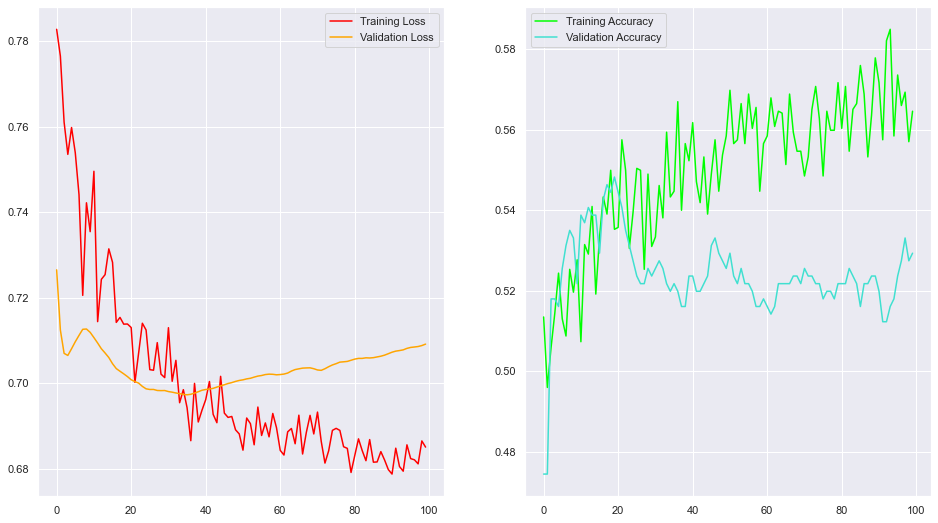

In [86]:
model = grid.best_estimator_
hist = model.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=100, validation_split=0.2, shuffle=False, verbose=0)
plot_model_hist(hist)

In [97]:
model.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=100, verbose=0)
model.score(x_test_blocks, y_test_blocks)

19/19 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.5486


0.5485519766807556

### Long Short Term Memory

In [98]:
def build_lstm(input_shape, units, dropout=0.0, optimizer='adam'):
    # build a sequential model
    model = models.Sequential()
    
    # add input layer
    model.add(layers.InputLayer(input_shape=input_shape, name='input'))

    # add LSTM layers
    units = units.split(",")
    lstm_total = len(units)
    lstm_count = 0
    for unit in units:
        lstm_count += 1
        model.add(layers.LSTM(units=int(unit), return_sequences=(lstm_count != lstm_total), dropout=dropout))
    
    # add output layer
    model.add(layers.Dense(units=1, activation='sigmoid', name='output'))

    # compile and train for accuravy optimization
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

#### GridSearch for smaller dataset

In [103]:
input_shape_s = Xs_train_blocks.shape[1:]
clf = KerasClassifier(build_fn=build_lstm, input_shape=input_shape_s)

param_grid_s = {
    'units': [ '4,4' , '4,8,4', '16,32,16' ],
    'dropout': [ 0.1, 0.2, 0.3 ]
}

grid_s = GridSearchCV(clf, param_grid_s, cv=TimeSeriesSplit(), verbose=1)
grid_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=100, verbose=0);

Fitting 5 folds for each of 9 candidates, totalling 45 fits
13/13 [==============================] - 0s 4ms/step - loss: 0.7089 - accuracy: 0.4964


In [104]:
display_grid_results(grid_s, param_grid_s.keys())

,param_units,param_dropout,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,"4,4",0.1,6.929665,0.418347,0.524939,0.030528
1,"4,8,4",0.1,8.489799,1.707010,0.523002,0.051227
2,"4,4",0.2,5.723234,1.073138,0.516707,0.048441
3,"4,8,4",0.3,9.430999,1.165622,0.516223,0.052591
4,"4,4",0.3,6.082966,1.498586,0.507990,0.036702
5,"4,8,4",0.2,9.470492,2.379185,0.493947,0.056743
6,"16,32,16",0.1,8.447947,1.822909,0.475545,0.027802
7,"16,32,16",0.3,10.084972,1.614285,0.461017,0.035671
8,"16,32,16",0.2,8.903345,2.414758,0.456659,0.037279


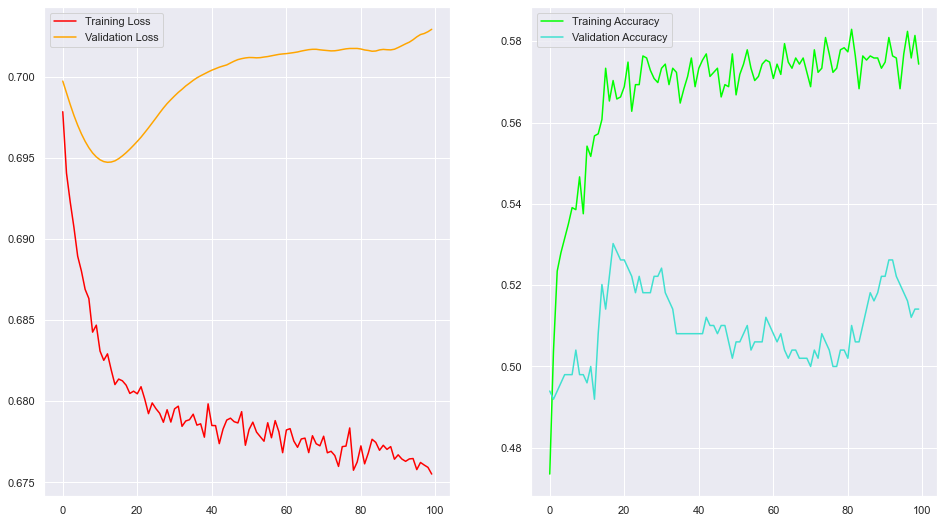

In [105]:
model_s = grid_s.best_estimator_
hist_s = model_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=100, validation_split=0.2, shuffle=False, verbose=0)
plot_model_hist(hist_s)

In [107]:
model_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=100, verbose=0)
model_s.score(xs_test_blocks, ys_test_blocks)

18/18 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5531


0.553113579750061

#### GridSearch for the entire dataset

In [108]:
input_shape = X_train_blocks.shape[1:]
clf = KerasClassifier(build_fn=build_lstm, input_shape=input_shape)

param_grid = {
    'units': [ '4,4', '4,8,4', '8,16,8' ],
    'dropout': [ 0.2, 0.4, 0.6 ]
}

grid = GridSearchCV(clf, param_grid, cv=TimeSeriesSplit(), verbose=1)
grid.fit(X_train_blocks, Y_train_blocks, batch_size=256, epochs=500, verbose=0);

Fitting 5 folds for each of 9 candidates, totalling 45 fits
14/14 [==============================] - 0s 5ms/step - loss: 0.7133 - accuracy: 0.5227


In [109]:
display_grid_results(grid, param_grid.keys())

,param_units,param_dropout,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,"8,16,8",0.2,35.710533,11.146010,0.545000,0.022333
1,"4,8,4",0.6,35.406063,15.024598,0.541364,0.026637
2,"4,4",0.6,23.489728,7.610978,0.534091,0.026426
3,"4,4",0.4,26.404272,9.351695,0.530000,0.022971
4,"4,8,4",0.4,35.365106,13.282632,0.526818,0.033476
5,"4,4",0.2,27.030319,11.034562,0.522727,0.043952
6,"4,8,4",0.2,34.956439,12.061730,0.517727,0.038607
7,"8,16,8",0.4,33.424901,10.924004,0.515455,0.025849
8,"8,16,8",0.6,34.372338,10.857861,0.498636,0.013143


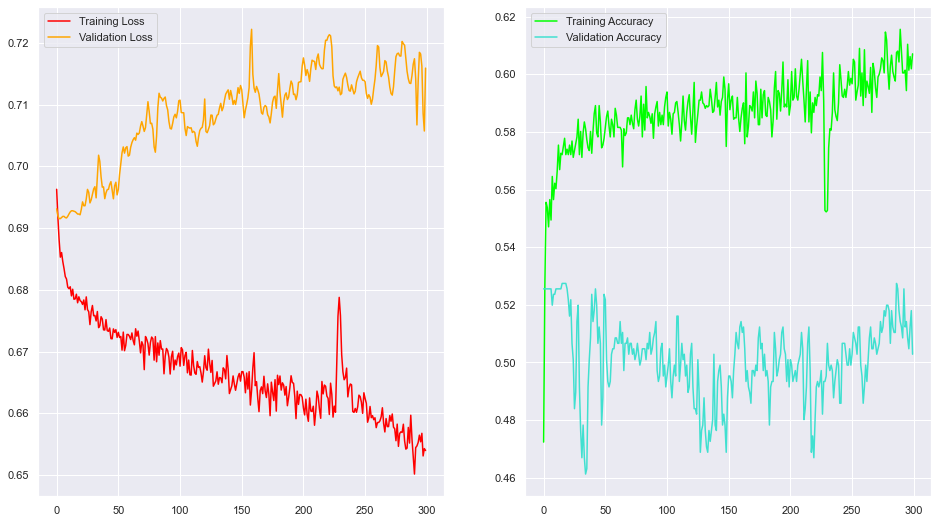

In [111]:
model = grid.best_estimator_
hist = model.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=300, validation_split=0.2, shuffle=False, verbose=0)
plot_model_hist(hist)

In [114]:
model.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=300, verbose=0)
model.score(x_test_blocks, y_test_blocks)

19/19 [==============================] - 0s 5ms/step - loss: 0.7079 - accuracy: 0.5537


0.5536627173423767

### CNN - LSTM

In [115]:
def build_cnn_lstm(input_shape, cnn_filters, cnn_kernel, dense_inter, lstm_units, dense_last, dropout=0.0, dense_activ='relu', optimizer='adam'):
    # build a sequential model
    model = models.Sequential()

    # add input layer
    model.add(layers.InputLayer(input_shape=input_shape, name='input'))

    # add CNN layers
    cnn_filters = cnn_filters.split(",")
    for filter in cnn_filters:
        model.add(layers.Conv1D(int(filter), cnn_kernel))
        model.add(layers.MaxPool1D())
    
    # add intermediate layer
    model.add(layers.Dense(units=dense_inter, activation=dense_activ, name='intermediate'))

    # add LSTM layers
    lstm_units = lstm_units.split(",")
    lstm_total = len(lstm_units)
    lstm_count = 0
    for unit in lstm_units:
        lstm_count += 1
        model.add(layers.LSTM(int(unit), return_sequences=(lstm_count != lstm_total)))
    
    # add last hidden layer
    model.add(layers.Dense(units=dense_last, activation=dense_activ, name='last_hidden'))
    
    # add output layer
    model.add(layers.Dense(units=1, activation='sigmoid', name='output'))

    # compile and train for accuravy optimization
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

#### GridSearch for the smaller dataset

In [193]:
input_shape_s = Xs_train_blocks.shape[1:]
clf = KerasClassifier(build_fn=build_cnn_lstm, input_shape=input_shape_s, cnn_kernel=5, dense_inter=32, lstm_units='4,4', dense_last=8)

param_grid_s = {
    'cnn_filters': [ '16,32,16', '8,16,8' ],
    'dropout': [ 0.1, 0.2, 0.3 ]
}

grid_s = GridSearchCV(clf, param_grid_s, cv=TimeSeriesSplit(), verbose=1)
grid_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=100, verbose=0);

Fitting 5 folds for each of 6 candidates, totalling 30 fits
13/13 [==============================] - 0s 4ms/step - loss: 0.7069 - accuracy: 0.4964


In [194]:
display_grid_results(grid_s, param_grid_s.keys())

,param_cnn_filters,param_dropout,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,"8,16,8",0.1,7.032094,0.763415,0.530266,0.036174
1,"8,16,8",0.3,6.875127,1.240445,0.507506,0.027032
2,"8,16,8",0.2,7.096140,1.247675,0.499758,0.027505
3,"16,32,16",0.1,7.140461,0.460761,0.497821,0.044028
4,"16,32,16",0.3,8.145004,1.655460,0.471671,0.041443
5,"16,32,16",0.2,9.902261,3.285702,0.461017,0.037090


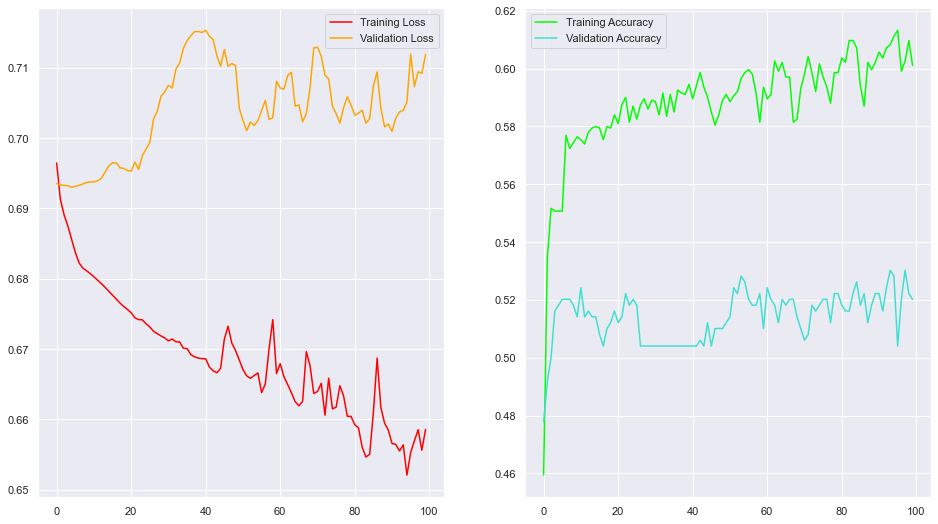

In [195]:
model_s = grid_s.best_estimator_
hist = model_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=100, validation_split=0.2, shuffle=False, verbose=0)
plot_model_hist(hist)

In [202]:
model_s.fit(Xs_train_blocks, Ys_train_blocks, batch_size=512, epochs=100, verbose=0)
model_s.score(xs_test_blocks, ys_test_blocks)

18/18 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.5476


0.5476190447807312

#### GridSearch for the entire dataset

In [144]:
input_shape = X_train_blocks.shape[1:]
clf = KerasClassifier(build_fn=build_cnn_lstm, input_shape=input_shape, cnn_kernel=5, dense_inter=32, lstm_units='4,4', dense_last=8)

param_grid = {
    'cnn_filters': [ '16,32,16', '32,16,8' ],
    'dropout': [ 0.1, 0.2, 0.3 ]
}

grid = GridSearchCV(clf, param_grid, cv=TimeSeriesSplit(), verbose=1)
grid.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=100, verbose=0);

Fitting 5 folds for each of 12 candidates, totalling 60 fits
14/14 [==============================] - 0s 3ms/step - loss: 0.7339 - accuracy: 0.4727


In [145]:
display_grid_results(grid, param_grid.keys())

,param_cnn_filters,param_lstm_units,param_dropout,mean_fit_time,std_fit_time,mean_test_score,std_test_score
0,"16,32,16","4,4",0.2,6.718363,1.118251,0.547273,0.020850
1,"32,16,8","4,4",0.2,8.393520,4.354195,0.541364,0.031831
2,"16,32,16","4,4",0.1,6.911400,0.722312,0.533182,0.033235
3,"32,16,8","4,4",0.3,6.702800,0.752465,0.531818,0.035877
4,"32,16,8","4,4",0.1,7.373810,1.492814,0.530455,0.032416
5,"32,16,8","8,8",0.1,6.908357,0.939924,0.530000,0.036403
6,"32,16,8","8,8",0.3,6.886002,1.061760,0.525909,0.043849
7,"16,32,16","8,8",0.1,8.182410,3.026797,0.523636,0.032416
8,"16,32,16","4,4",0.3,6.544094,1.255528,0.516818,0.005856
9,"32,16,8","8,8",0.2,6.639924,1.083456,0.516364,0.035889


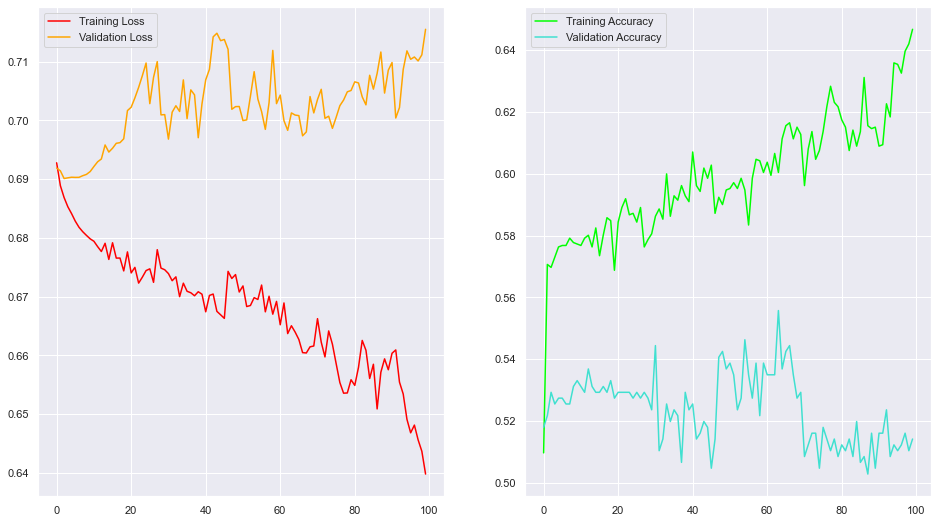

In [146]:
model = grid.best_estimator_
hist = model.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=100, validation_split=0.2, shuffle=False, verbose=0)
plot_model_hist(hist)

In [149]:
model.fit(X_train_blocks, Y_train_blocks, batch_size=512, epochs=100, verbose=0)
model.score(x_test_blocks, y_test_blocks)

19/19 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.5554


0.5553662776947021